In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans

# Tạo Spark session
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

# Đọc file CSV
df = spark.read.csv("../../../data/Chiller.csv", header=True, inferSchema=True)

# Hiển thị dữ liệu
df.show()

# Lựa chọn các cột cần thiết và bỏ qua cột đầu tiên
columns = df.columns
features_columns = columns[1:]

# Tạo VectorAssembler để chuyển đổi các cột tính năng thành một cột vector duy nhất
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
df_features = assembler.transform(df)

# Hiển thị DataFrame với cột "features"
df_features.show()


+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+
|               Time|X-Acceleration|Y-Acceleration|Z-Acceleration| X-Velocity| Y-Velocity| Z-Velocity|Composite-Acceleration|Composite-Velocity|Temperature Z|Temperature-XYZ|X-Velocity_predictions|
+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+
|2022-12-01 12:00:00|    15.1796875|      16.15625|    10.4921875| 1.62109375|1.877929688|1.686523438|             17.515625|               3.0|        19.25|          19.25|                 1.621|
|2022-12-01 13:00:00|      16.09375|    15.3515625|     10.421875|1.466796875|1.686523438|1.462890625|               18.9375|          2.671875|        18.75|          18.75|                 1.467|
|2022-12-0

Áp dụng thuật toán KMeans với MLlib

In [7]:
# Tạo mô hình KMeans
kmeans = KMeans(featuresCol="features", k=2)  # Số lượng cluster là 2, 1 cho dữ liệu bình thường và 1 cho bất thường
model = kmeans.fit(df_features)

# Dự đoán cluster cho từng điểm dữ liệu
predictions = model.transform(df_features)

# Hiển thị kết quả dự đoán
predictions.show()


+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+--------------------+----------+
|               Time|X-Acceleration|Y-Acceleration|Z-Acceleration| X-Velocity| Y-Velocity| Z-Velocity|Composite-Acceleration|Composite-Velocity|Temperature Z|Temperature-XYZ|X-Velocity_predictions|            features|prediction|
+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+--------------------+----------+
|2022-12-01 12:00:00|    15.1796875|      16.15625|    10.4921875| 1.62109375|1.877929688|1.686523438|             17.515625|               3.0|        19.25|          19.25|                 1.621|[15.1796875,16.15...|         0|
|2022-12-01 13:00:00|      16.09375|    15.3515625|     10.421875|1.466796875|1.

Đánh dấu và hiển thị các điểm bất thường

+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+--------------------+----------+-------+
|               Time|X-Acceleration|Y-Acceleration|Z-Acceleration| X-Velocity| Y-Velocity| Z-Velocity|Composite-Acceleration|Composite-Velocity|Temperature Z|Temperature-XYZ|X-Velocity_predictions|            features|prediction|anomaly|
+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+--------------------+----------+-------+
|2022-12-01 12:00:00|    15.1796875|      16.15625|    10.4921875| 1.62109375|1.877929688|1.686523438|             17.515625|               3.0|        19.25|          19.25|                 1.621|[15.1796875,16.15...|         0|      0|
|2022-12-01 13:00:00|      16.09375|    15.35156

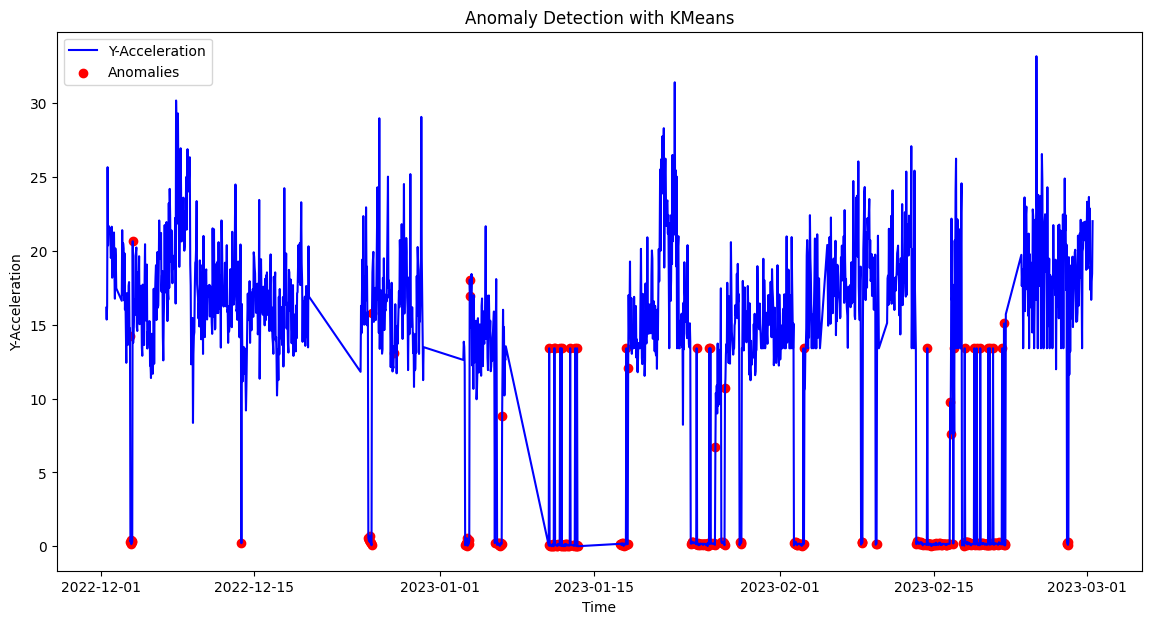

In [10]:
# Thêm cột "anomaly" dựa trên cluster prediction
predictions = predictions.withColumn("anomaly", predictions["prediction"])

# Hiển thị kết quả với cột anomaly
predictions.show()

# Chuyển đổi lại thành Pandas DataFrame để vẽ biểu đồ nếu cần
pandas_df = predictions.toPandas()
selected_column ="Y-Acceleration"
import matplotlib.pyplot as plt

# Vẽ biểu đồ line với trục X là Timestamp và trục Y là selected_column
plt.figure(figsize=(14, 7))
plt.plot(pandas_df[columns[0]], pandas_df[selected_column], label=selected_column, color='blue')

# Vẽ các điểm bất thường bằng scatter màu đỏ
anomalies = pandas_df[pandas_df["anomaly"] == 1]  # Giả sử cluster 1 là các điểm bất thường
plt.scatter(anomalies[columns[0]], anomalies[selected_column], color='red', label="Anomalies")

plt.xlabel(columns[0])
plt.ylabel(selected_column)
plt.legend()
plt.title("Anomaly Detection with KMeans")
plt.show()
